# Load library

In [1]:
library("DESeq2")


Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The follow

# Read count table
This count table is generated from the diffpeak pipeline: https://hemtools.readthedocs.io/en/latest/content/Differential_analysis/deseq2_diffpeak.html?highlight=diffpeak

In [2]:
infile="DiffPeak_syi_2021-11-16.count_table.bed"
countData = read.csv(infile,sep="\t")
head(countData)

,Geneid,Chr,Start,End,Strand,Length,X1098561_Hudep2_CTCF.rmdup.uq.bam,X1047954_Hudep2_CTCF_50bp.rmdup.uq.bam,X2268629_KO_29_CTCF_S134_L004.rmdup.uq.bam,X2268630_KO_68_CTCF_S135_L004.rmdup.uq.bam
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>
1,region_1,chr1,15918,16556,+,639,52,34,278,32
2,region_2,chr1,54581,54686,+,106,6,9,38,3
3,region_3,chr1,91023,91696,+,674,38,15,381,130
4,region_4,chr1,104705,105259,+,555,40,34,150,34
5,region_5,chr1,115570,115837,+,268,35,19,140,23
6,region_6,chr1,138518,139511,+,994,32,20,268,24


# Specify design matrix, control + treatment

In [3]:
group1=c("X1098561_Hudep2_CTCF.rmdup.uq.bam","X1047954_Hudep2_CTCF_50bp.rmdup.uq.bam") # WT
group2=c("X2268629_KO_29_CTCF_S134_L004.rmdup.uq.bam","X2268630_KO_68_CTCF_S135_L004.rmdup.uq.bam") # KO
group_label <- c(rep("control", length(group1)), rep("treatment", length(group2)))


In [4]:
group_label

[1] "control"   "control"   "treatment" "treatment"

# Get count matrix

In [5]:
mat <- countData[,7:10]
rownames(mat) <- countData[,1]
head(mat)

,X1098561_Hudep2_CTCF.rmdup.uq.bam,X1047954_Hudep2_CTCF_50bp.rmdup.uq.bam,X2268629_KO_29_CTCF_S134_L004.rmdup.uq.bam,X2268630_KO_68_CTCF_S135_L004.rmdup.uq.bam
,<int>,<int>,<int>,<int>
region_1,52,34,278,32
region_2,6,9,38,3
region_3,38,15,381,130
region_4,40,34,150,34
region_5,35,19,140,23
region_6,32,20,268,24


# RUN DEseq2

In [6]:
sample_info <- data.frame(sampleName=c(group1, group2), Group=group_label)
dds <- DESeqDataSetFromMatrix(countData=mat, colData=sample_info, design=~Group)
dds = DESeq(dds) # main function
res=results(dds)
raw_count = counts(dds)
norm_count = counts(dds,normalized=TRUE)


Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Save result (this is the result without LFC shrinkage)

In [7]:
outfile="deseq2.result"
colnames(norm_count) = paste(colnames(norm_count),".norm",sep="")
d <- data.frame(countData,norm_count, logFC=res[,"log2FoldChange"], AveExpr=res[,"baseMean"], t=res[,"stat"], P.Value=res[,"pvalue"], adj.P.Val=res[,"padj"])
d <- d[order(d[,"P.Value"]),]
write.table(d, file=paste(outfile, ".deseq2_wo_lfcShrink.tsv", sep=""), sep="\t", quote=FALSE, row.names=FALSE)

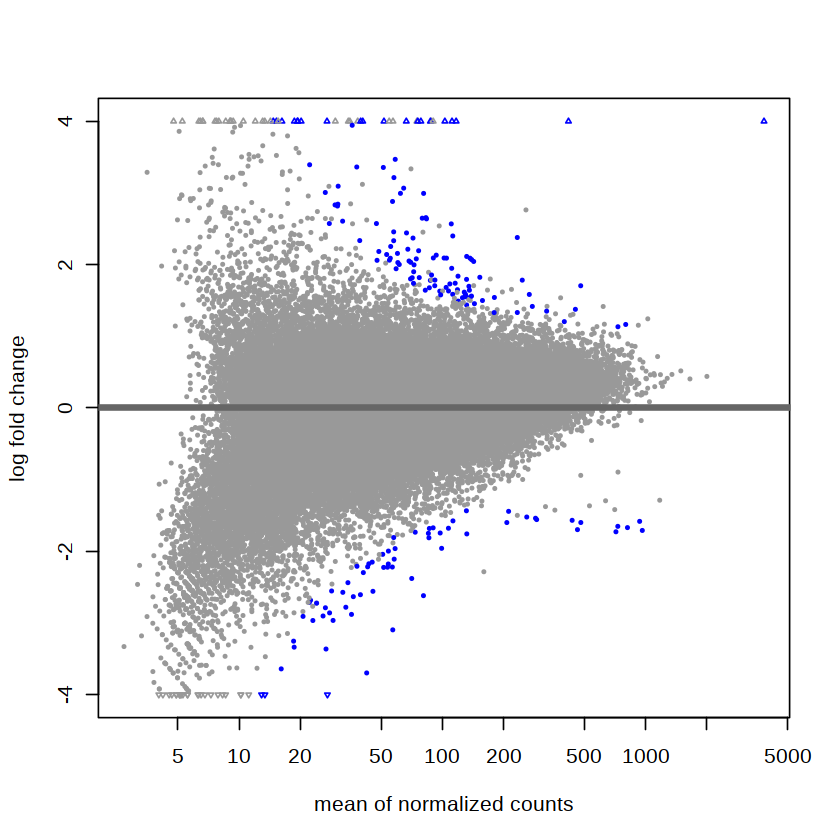

In [8]:
plotMA(res, ylim = c(-4, 4))

# apply LFC shrinkage 

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



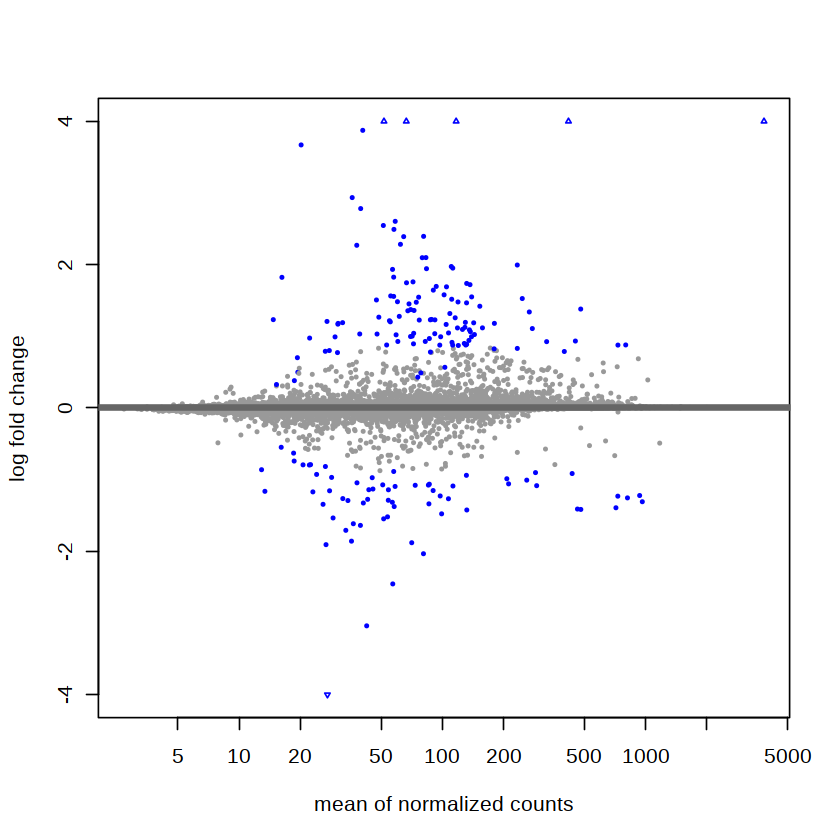

In [10]:
res <- lfcShrink(dds,coef="Group_treatment_vs_control", type="ashr")
plotMA(res, ylim = c(-4, 4))

# save new result

In [12]:
head(res)

log2 fold change (MMSE): Group treatment vs control 
Wald test p-value: Group treatment vs control 
DataFrame with 6 rows and 5 columns
          baseMean log2FoldChange     lfcSE      pvalue       padj
         <numeric>      <numeric> <numeric>   <numeric>  <numeric>
region_1  63.44804     0.00805928 0.0788364 3.31818e-01 0.99770039
region_2   9.55499    -0.00183120 0.1008589 8.50857e-01         NA
region_3 110.64886     1.97421221 0.5220874 6.11724e-07 0.00147051
region_4  52.58138     0.00282279 0.0643666 6.94088e-01 0.99770039
region_5  38.47367     0.00579136 0.0769100 4.82171e-01 0.99770039
region_6  47.76244     0.03886980 0.1892013 6.02855e-02 0.90094156

In [13]:
outfile="deseq2.result"
colnames(norm_count) = paste(colnames(norm_count),".norm",sep="")
d <- data.frame(countData,norm_count, logFC=res[,"log2FoldChange"], AveExpr=res[,"baseMean"], P.Value=res[,"pvalue"], adj.P.Val=res[,"padj"])
d <- d[order(d[,"P.Value"]),]
write.table(d, file=paste(outfile, ".deseq2_with_lfcShrink.tsv", sep=""), sep="\t", quote=FALSE, row.names=FALSE)